# Heatmaps for DOP and Cramer Rao Bounds

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# We need to join the upper directory in order to access the local modules
import datetime
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [3]:
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{newtxmath}'
# plt.rcParams['text.latex.preamble'] += r'\usepackage{libertine}'
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

In [4]:
# Reading the mat files
with open("comnets_data/gnbPositions.json") as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])
center = gNBs[3,:]
Rba = np.array([[np.cos(np.pi/2),-np.sin(np.pi/2),center[0]],[np.sin(np.pi/2),np.cos(np.pi/2),center[1]],[0.0,0.0,1.0]])
Rab = np.linalg.inv(Rba)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])
ggs = np.hstack((gNBs,np.ones((4,1))))
gNBs = np.matmul(Rab,ggs.T).T
gNBs = gNBs[:,0:2]

with open("comnets_data/uePositions.json") as ue_file:
    data = json.load(ue_file)

UEs = np.array(
    [data["ue0"], data["ue1"], data["ue2"], data["ue3"], data["ue4"], data["ue5"]]
)

uus = np.hstack((UEs,np.ones((6,1))))

UEs = np.matmul(Rab,uus.T).T
UEs = UEs[:,0:2]

## Dilution of Precision & CRLB

Dilution of Precision is easiear to calculate as it depends on geometric parameters (CRLB under constant variance depends only on that too :D)
https://en.wikipedia.org/wiki/Dilution_of_precision_(navigation)

In [5]:
from pytdoa.geometry.estimators import dop, crlb

In [6]:
d = dop(UEs[0:5,:].reshape(-1,2), gNBs)
d

array([[0.06823607, 0.74903655],
       [0.06910904, 0.78901503],
       [0.07205499, 0.48230421],
       [0.07680169, 0.48387948],
       [0.0817966 , 0.34827208]])

In [7]:
cr = crlb(UEs[0:5,:].reshape(-1,2), gNBs, snr=10.0)
cr

array([[0.77573857, 8.51538732],
       [0.7856629 , 8.9698808 ],
       [0.8191538 , 5.4830531 ],
       [0.87311647, 5.50096146],
       [0.92990089, 3.95931497]])

In [16]:
n = 200
l = 7.0
x = np.linspace(np.min(gNBs[:,0])-l,np.max(gNBs[:,0])+l,n,endpoint=True)
y = np.linspace(np.min(gNBs[:,1])-l,np.max(gNBs[:,1])+l,n,endpoint=True)

xx, yy = np.meshgrid(x,y)

ps = np.hstack((xx.flatten().reshape(-1,1),yy.flatten().reshape(-1,1)))
dp = dop(ps, gNBs[:,:])
cr = crlb(ps, gNBs[:,:], snr=10.0)
xdop = np.sqrt(dp[:,0]).reshape(xx.shape)
ydop = np.sqrt(dp[:,1]).reshape(yy.shape)
hdop = np.sqrt(np.sum(dp,axis=1)).reshape(yy.shape)
crl = np.sqrt(np.sum(cr,axis=1)).reshape(yy.shape)
crlx = np.sqrt(cr[:,0].reshape(yy.shape))
crly = np.sqrt(cr[:,1].reshape(yy.shape))

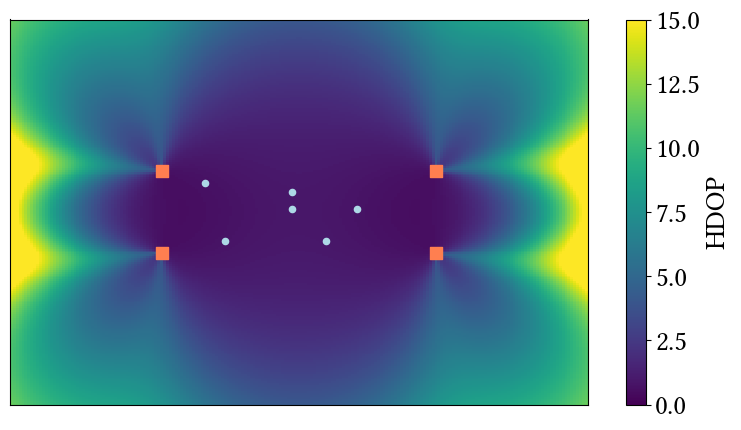

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

im = ax.pcolormesh(x,y,hdop,vmin=0.0,vmax=15)
c = fig.colorbar(im, ax=ax)
c.ax.set_ylabel('HDOP')

ax.set_xticks([])
ax.set_yticks([])

ax.scatter(UEs[:,0],UEs[:,1], 20, 'lightblue', 'o')
ax.scatter(gNBs[:,0], gNBs[:,1], 80, 'coral', 's')

# plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.savefig('../pics/comnets/hdop.pdf', format='pdf', bbox_inches='tight')
plt.show()

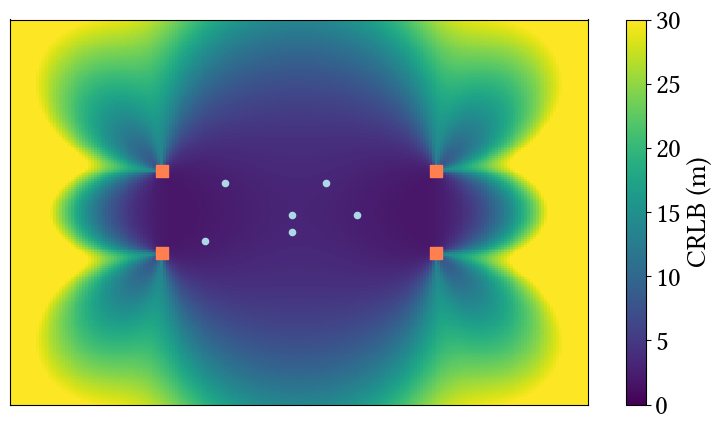

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

im = ax.pcolormesh(x,y,crl,vmin=0.0,vmax=30)
c = fig.colorbar(im, ax=ax)
c.ax.set_ylabel('CRLB (m)')

ax.set_xticks([])
ax.set_yticks([])

ax.scatter(UEs[:,0],UEs[:,1], 20, 'lightblue', 'o')
ax.scatter(gNBs[:,0], gNBs[:,1], 80, 'coral', 's')

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.savefig('../pics/comnets/crlb.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Small Test

In [93]:
from pytdoa.geometry.estimators import dop, crlb

In [94]:
gs = np.array([[0.0,0.0],[12.0,0.0],[12.0*np.cos(np.pi/3),-12.0*np.sin(np.pi/3)]])

In [95]:
n = 100
l = 20.0
x = np.linspace(np.min(gs[:,0])-l,np.max(gs[:,0])+l,400,endpoint=True)
y = np.linspace(np.min(gs[:,1])-l,np.max(gs[:,1])+l,400,endpoint=True)

xx, yy = np.meshgrid(x,y)

ps = np.hstack((xx.flatten().reshape(-1,1),yy.flatten().reshape(-1,1)))
cr = crlb(ps, gs, snr=20.0, bw=40e6)
cry = cr[:,1]
crl = np.sqrt(np.sum(cr,axis=1)).reshape(yy.shape)

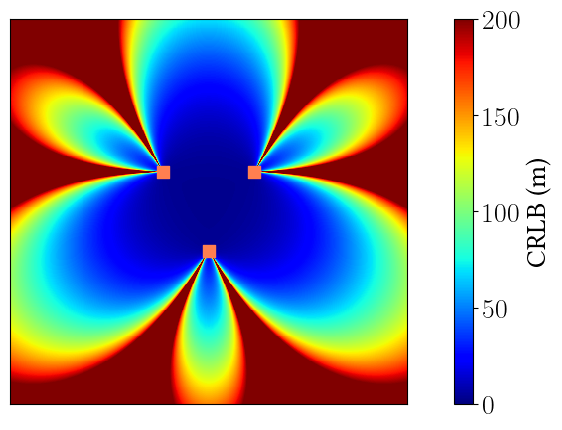

In [97]:
fig, ax = plt.subplots(figsize=(12, 5))

im = ax.pcolormesh(x,y,crl,vmin=0.0,vmax=200,cmap='jet')
c = fig.colorbar(im, ax=ax)
c.ax.set_ylabel(r'CRLB (m)')

ax.set_xticks([])
ax.set_yticks([])

ax.scatter(gs[:,0], gs[:,1], 80, 'coral', 's')

plt.gca().set_aspect('equal')
plt.show()